# Messy modelling: overfitting, cross-validation, and the bias-variance trade-off

## Introduction

In this post you will get to grips with perhaps the most essential concept in machine learning: the **bias-variance trade-off**. The main idea here is that you want to create models that are as good at prediction as possible but that are still applicable when looking at new data (i.e. are generalizable).  The danger is that you can easily create models that **overfit** to the local noise in the data, which isn't too helpful and leads to poor generalizability since the noise is random and different in each dataset. Essentially, you want to create models that capture only the useful components of the dataset. Models that generalize very well but are too inflexible to generate good predictions (they **underfit** the data) are the other extreme we want to avoid. 

We discuss and demonstrate these concepts using the k-nearest neighbours algorithm, which has a simple parameter k which can be varied to cleanly demonstrate these ideas of underfitting, overfitting and generalization. Together, this bundle of concepts related to the balance between underfitting and overfitting is called the bias-variance trade-off. Here is a table summarizing these different aspects of models, which you can refer to throughout this post.
![Bias variance trade-off table](https://raw.githubusercontent.com/nslatysheva/data_science_blogging/master/messy_modelling/bias_variance_table.png "Bias variance trade-off summary table")

We will explain what all of these terms mean, how they are inter-related, and will also discuss **cross-validation**, which is a good way of estimating the accuracy and generalizability of your models. 

You will encounter all of these concepts in the next few blog posts in this series, which will cover model optimization, random forests, Naive Bayes, logistic regression and combining different models into an ensembled meta-model. 

## Generating the dataset

Let's start off by building an artificial dataset to play with. We can do this easily with the `make_classification()` function from the `sklearn.datasets` package. Specifically, we will generate a relatively simple binary classification problem. To make it a bit more interesting, let's make the data crescent-shaped and add some random noise. This should make it more realistic and increase the difficulty of classifying observations.

In [79]:
# Creating the dataset
# e.g. make_moons generates crescent-shaped data
# Check out make_classification, which generates ~linearly-separable data
from sklearn.datasets import make_moons

X, y = make_moons(
    n_samples=500,  # the number of observations
    random_state=1,
    noise=0.3 #0.3
)

# Take a peek
print(X[:10,])
print(y[:10])

[[ 0.50316464  0.11135559]
 [ 1.06597837 -0.63035547]
 [ 0.95663377  0.58199637]
 [ 0.33961202  0.40713937]
 [ 2.17952333 -0.08488181]
 [ 2.00520942  0.7817976 ]
 [ 0.12531776 -0.14925731]
 [ 1.06990641  0.36447753]
 [-0.76391099 -0.6136396 ]
 [ 0.55678871  0.8810501 ]]
[1 1 0 0 1 1 1 0 0 0]


The dataset we just generated looks like this:

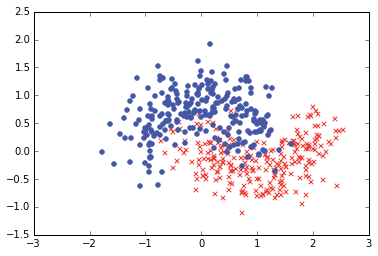

In [80]:
import matplotlib.pyplot as plt

%matplotlib inline

# Plot the first feature against the other, color by class
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="#EE3D34", marker="x")
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="#4458A7", marker="o")

Next up, let's split the dataset into a training and test set. The training set will be used to develop and tune our models. The test set will be completely left alone until the very end, at which point you'll run your finished models on it. Having a test set will allow you to get a good estimate of how well your models would perform out in the wild on unseen data.

In [81]:
from sklearn.cross_validation import train_test_split

# Split into training and test sets
XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1)

We are going to try to predict the classes with a k Nearest Neighbor (kNN) classifier. Chapter 2 of the [Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Sixth%20Printing.pdf) book provides a great intro to the theory behind kNN. We are huge fans of the ISLR book, so definitely check it out if you have the time. You could also have a look at this previous post that teaches you [how to implement the algorithm from scratch in Python](http://blog.cambridgecoding.com/2016/01/16/machine-learning-under-the-hood-writing-your-own-k-nearest-neighbour-algorithm/).

## Introducing the k hyperparameter in kNN

The kNN algorithm works by using information on the k-nearest neighbours of a new data point in order to classify it into a class. It simply looks at the class of other data points most similar to it (its 'nearest neighbours') and assigns the most common class of these neighbours. When using kNN, you have to set the value of `k` that you want the algorithm to use ahead of time, and it is not trivial to know which value to use.

If the value for `k` is high (e.g. `k=99`), then the model considers a large number of neighbours when making a a decision about the class of an unknown datapoint. This means that the model is quite constrained, since it has to take a large amount of information into account when classifying instances. In other words, a high number for `k` give rise to relatively "rigid" model behaviour.

By constrast, if the value for `k` is low (e.g. `k=1` or `k=2`), then only a few neighbours are taken into account when making a classification decision. It is a very flexible model with a lot of complexity - it really fits very closely to the precise shape of the dataset. Hence, the predictions of the model are much more dependent on the local tendencies of the data (crucially, this includes the noise!). 

Take a look at how the kNN algorithm separates the training cases when `k=99` compared to when `k=1`. The green line is the decision boundary on the training data (i.e. the point at which the algorithm decides whether a data point as being blue or red).

![Differences in model fit when k=99 and k=1](https://raw.githubusercontent.com/nslatysheva/data_science_blogging/master/messy_modelling/knn_99_1.png "Differences in model fit when k=99 and k=1")

In a minute, you'll learn to generate these plots yourself.

When `k=99` (on the left), it looks like the model fit might be a bit too smooth and could stand to fit the data a bit closer. The model has **low flexibility** and **low complexity**. It paints the decision boundary with a broad brush. It has relatively **high bias** because we can tell it is not modelling the data as well as it could - it models the underlying generative process of the data as something too simple, and this is highly biased away from the ground truth. But, the decision boundary would probably look very similar if we redrew it on a slightly different dataset. It is a stable model that won't vary a lot - it has **low variance**.


When `k=1` (on the right), you can see that the model is massively overfitting to the noise. It is technically perfectly correct on the training set (the error in the bottom right hand corner is equal to 0.00!), but hopefully you can see how this fit is way too sensitive to individual data points. Keep in mind we added noise to the dataset - it looks like this model fit is taking the noise too seriously and is fitting very closely to it. We can say that the `k=1` model has **high flexibility** and **high complexity**. It tunes very tightly to the data. It also has **low bias** - if nothing else, the decision boundary certainly fits the trends in the data. But, the fitted boundary would drastically change on even slightly different data - it would vary significantly, i.e. the `k=1` model has **high variance**.

But how well do these models **generalize**, i.e. how well would they perform on new data?

We have so far only looked at the training data, but quantifying training error isn't that useful. We want to know how well the models are modelling the underlying generative process of the data, not how well they recapitulate what they just learned on the training set. Let's take a look at how they perform on test data, since that gives a better impression of whether our models are actually good or not.

In [82]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

knn99 = KNeighborsClassifier(n_neighbors = 99)
knn99.fit(XTrain, yTrain)
yPredK99 = knn99.predict(XTest)
print "Overall Error of k=99 Model:", 1 - round(metrics.accuracy_score(yTest, yPredK99), 2)

knn1 = KNeighborsClassifier(n_neighbors = 1)
knn1.fit(XTrain, yTrain)
yPredK1 = knn1.predict(XTest)
print "Overall Error of k=1 Model:", 1 - round(metrics.accuracy_score(yTest, yPredK1), 2)

Overall Error of k=99 Model: 0.14
Overall Error of k=1 Model: 0.14


Actually, it looks like these models perform approximately as well on the test data. Here are the decision boundaries we learned on the training set, applied to the test set. See if you can figure out where the two models are making their mistakes. 

![Test set performance for k=99 and k=1](https://raw.githubusercontent.com/nslatysheva/data_science_blogging/master/messy_modelling/test_train_example.png "Test set performance for k=99 and k=1")

It seems that the `k=99` model isn't capturing the crescent shape of the data (it is underfitting), while the `k=1` model is making mistakes from being horribly overfitted. The hallmark of overfitting is good training performance and bad testing performance, which is what we see here.

Maybe intermediate values of k are where we want to be? Let's give it a shot:

In [89]:
knn50 = KNeighborsClassifier(n_neighbors = 50)
knn50.fit(XTrain, yTrain)
yPredK50 = knn50.predict(XTest)
print "Overall Error of k=50 Model:", 1 - round(metrics.accuracy_score(yTest, yPredK50), 2)

Overall Error of k=50 Model: 0.11


Looking better! Let's check out the decision boundary for the k=50 model.

![Test set performance for k=99, k=50, and k=1](https://raw.githubusercontent.com/nslatysheva/data_science_blogging/master/messy_modelling/99_50_1_example.png "Test set performance for k=99, k=50, and k=1")


Much better - the model fit is similar to the actual trend in the dataset and this improvement is reflected in a lower test set error. 

## Other comments

Hopefully you now have a good intuition over what it means for models to underfit and overfit. See if all of the terms in the beginning of this post now make sense.

Before we throw tons of code at you, let's finish up talking about the bias-variance trade-off.

To recap, when we train machine learning algorithms on a dataset, what we are really interested in is how our model will perform on an independent data set. It is not enough to do a good job classifying instances on the training set. Essentially, we are only interested in building models that are **generalizable** - getting 100% accuracy on the training set is not impressive, and is simply an indicator of **overfitting**. Overfitting is the situation in which we have fitted our model too closely to the data, and have tuned to the noise instead of just to the signal.

Here is a summary figure showing how under-fitting (high bias, low variance), properly fitting, and over-fitting (low bias, high variance) models fare on the training compared to the test sets:

![Under-fitting, properly fitting, and over-fitting models](https://raw.githubusercontent.com/nslatysheva/data_science_blogging/master/messy_modelling/over_underfitting.png "Under-fitting, properly fitting, and over-fitting models")

This idea of building generalizable models is the motivation behind splitting your dataset into a **training set** (on which models can be trained) and a **test set** (which is held out until the very end of your analysis, and provides an accurate measure of model performance). 

But - big warning! It's also possibly to overfit to the test set. If we were to try lots of different models out and keep changing them to increase test set accuracy, then the information from the test set can inadvertently leak into our model creation phase, which is a big no-no. One way of getting around this is by using cross-validation.

## Estimating model performance using k-fold cross validation

Enter **k-fold cross-validation**, which is a handy technique for measuring a model's performance using *only* the training set. Say that we want to do e.g. 10-fold cross-validation. The process is as follows: we randomly partition the training set into 10 equal sections. Then, we train an algorithm on 9/10ths (i.e. 9 out of the 10 sections) of that training set. We then evaluate its performance on the remaining 1 section. This gives us some measure of the model's performance (e.g. overall accuracy). We then train the algorithm on a *different* 9/10ths of the training set, and evaluate on the other (different from before) remaining 1 section. We continue the process 10 times, get 10 different measures of model performance, and average these values to get an overall measure of performance. Of course, we could have chosen some number other than 10. To keep on with the example, the process behind 10-fold CV looks like this:

![Diagram showing the steps behind 10-fold cross-validation.](./cv.png "10-fold CV")

We can use k-fold cross validation to get an estimate of model accuracy, and we can use these estimates to tweak our model until we are happy. This lets us leave the test data alone until the very end, thus side-stepping the danger of overfitting to it. k-fold cross validation is extremely popular and very useful, especially if you're trying out lots and lots of different models (e.g. if you want to test how well lots of differently parameterized models perform).


## What about datasets without lots of noise?

Whew, lots of theory. Just a bit more!

We have been talking about how overfitting occurs when models starting tuning to the noise. But what if we had a dataset without a lot of noise? Would overfitting really be so bad then? For example, say we had this dataset:

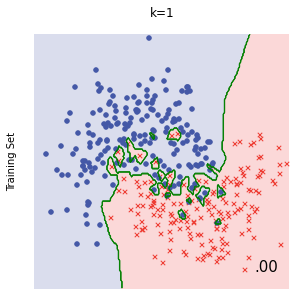

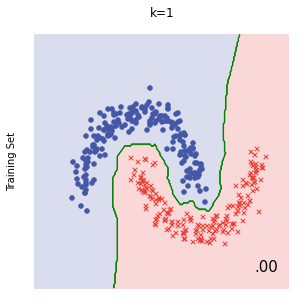

In [92]:
# Let's tone down the noise in the dataset
X_no_noise, y_no_noise = make_moons(
    n_samples=500,  # the number of observations
    random_state=1,
    noise=0.1
)

# Split into training and test sets
XTrain_no_noise, XTest_no_noise, yTrain_no_noise, yTest_no_noise = train_test_split(X_no_noise, y_no_noise, random_state=1)

model = KNeighborsClassifier()
datasets = {"Training Set": [XTrain, yTrain]}

explore_fitting_boundaries(model=model, n_neighbors=[1], datasets={"Training Set": [XTrain, yTrain]}, width=5)
explore_fitting_boundaries(model=model, n_neighbors=[1], datasets={"Training Set": [XTrain_no_noise, yTrain_no_noise]}, width=5)

Most real-life datasets will be full of noise, so overfitting is always a danger. However, what exactly consistutes "overfitting" will differ tremendously between datasets, and you have to decide what course of action is optimal. The best guidance is your model's performance on the test set and on cross-validation. If a model that "should" be overfitting is actually generalizing well, then no need to worry.

## Show me the code!

Aha, you've made it this far. Here is our code for generating the above plots, and doing the training and testing of different kNN algorithms. This code is largely a simplified version of [this scikit-learn example](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

In [28]:
import numpy as np

def detect_plot_dimension(X, h=0.02, b=0.05):
    '''
    Function to detect the plot dimensions (considering Training and Test data)
    Parameters: X - the dataset
                h - the granularity of the visual display of the boundary
                b - the space buffer at the extreme values
    '''
    x_min, x_max = X[:, 0].min() - b, X[:, 0].max() + b
    y_min, y_max = X[:, 1].min() - b, X[:, 1].max() + b
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    dimension = xx, yy
    return dimension
    

def detect_decision_boundary(dimension, model):
    '''
    Function to detect the decision boundaries
    Parameters: dimension - the plot dimension as calculated by detect_plot_dimension()
                model     - the model used for the prediction
    '''
    xx, yy = dimension  # unpack the dimensions
    boundary = model.predict(np.c_[xx.ravel(), yy.ravel()])
    boundary = boundary.reshape(xx.shape)  # Put the result into a color plot
    return boundary


def plot_decision_boundary(panel, dimension, boundary, colors=['#DADDED', '#FBD8D8']):
    '''
    Function to plot decision boundary
    Parameters: panel     - the plotting element to modify
                dimension - the plot dimension as calculated by detect_plot_dimension()
                boundary  - boundary tuple as calculated by detect_decision_boundary()
                colors    - the colors to use for the boundary surface
    '''
    xx, yy = dimension  # unpack the dimensions
    panel.contourf(xx, yy, boundary, cmap=ListedColormap(colors), alpha=1)
    panel.contour(xx, yy, boundary, colors="g", alpha=1, linewidths=0.5)  # the decision boundary in green


def plot_dataset(panel, X, y, colors=["#EE3D34", "#4458A7"], markers=["x", "o"]):
    '''
    Function to plot the observations of of a dataset with their class assigment
    Parameters: panel   - the plotting element to modify
                X       - the predictor dataset
                y       - the classification
                colors  - the color of the two classes
                markers - the markers to represent the two classes
    '''
    
    panel.scatter(X[y == 1, 0], X[y == 1, 1], color=colors[0], marker=markers[0])#, s=6)
    panel.scatter(X[y == 0, 0], X[y == 0, 1], color=colors[1], marker=markers[1])#, s=6)


def calculate_prediction_error(model, X, y):
    '''
    Function to estimate the prediction error
    Parameters: model - the model used for the prediction
                X     - the predictor dataset
                y     - the classification
    '''
    yPred = model.predict(X)
    score = 1 - round(metrics.accuracy_score(y, yPred), 2)
    return score


def plot_prediction_error(panel, dimension, score, b=.3):
    '''
    Function to plot the prediction error in the bottom right of the plot
    Parameters: panel     - the plotting element to modify
                dimension - the plot dimension as calculated by detect_plot_dimension()
                score     - the prediciton error as calculated by calcualte_prediciton_error()
                b         - the offset of the text from the bottom right
    '''
    xx, yy = dimension  # unpack the dimensions
    panel.text(xx.max() - b, yy.min() + b, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')

In [40]:
def explore_fitting_boundaries(model, n_neighbors, datasets, width): #direction="vertical"):
    '''
    Function to produce a grid of k number of neighbours (x-axis) against different datasets
    tested (y-axis)
    Note: Only supplying one dataset works
    Parameters: model       - the model to be tested (assumes KNeighborsClassifier())
                n_neighbors - a list of the the number k to be tested
                datasets    - a dictionary of lists with each a training and a test set
                figsize     - the dimension of the plot
                # direction   - should the comparable plots be arranged verically or horizontally
    '''
    
    # determine the height of the plot given the aspect ration of each panel should be equal
    height = float(width)/len(n_neighbors) * len(datasets.keys())

    nrows = len(datasets.keys())
    ncols = len(n_neighbors)
    
    # set up the plot
    figure, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(width, height),
        sharex=True,
        sharey=True
    )

    dimension = detect_plot_dimension(X, h=0.02)  # the dimension each subplot based on the data

    i = 0
    for n in n_neighbors:
        model.n_neighbors = n
        model.fit(datasets["Training Set"][0], datasets["Training Set"][1])
        boundary = detect_decision_boundary(dimension, model)
        j = 0
        for d in datasets.keys():
            try:
                panel = axes[j, i]
            except (TypeError, IndexError):
                if (nrows * ncols) == 1:
                    panel = axes
                elif nrows == 1:  # if we only have one dataset
                    panel = axes[i]
                elif ncols == 1:  # if we only try one number of neighbors
                    panel = axes[j]
            plot_decision_boundary(panel, dimension, boundary)  # plot the decision boundary
            plot_dataset(panel, X=datasets[d][0], y=datasets[d][1])  # plot the observations
            score = calculate_prediction_error(model, X=datasets[d][0], y=datasets[d][1])
            plot_prediction_error(panel, dimension, score, b=0.2)  # plot the score
            # make compacted layout
            panel.set_frame_on(False)
            panel.set_xticks([])
            panel.set_yticks([])
            # format the axis labels
            if i == 0:
                panel.set_ylabel(d)
            if j == 0:
                panel.set_title('k={}'.format(n))
            j += 1
        i += 1    

    plt.subplots_adjust(hspace=0, wspace=0)  # make compacted layout

We then run the code like this:

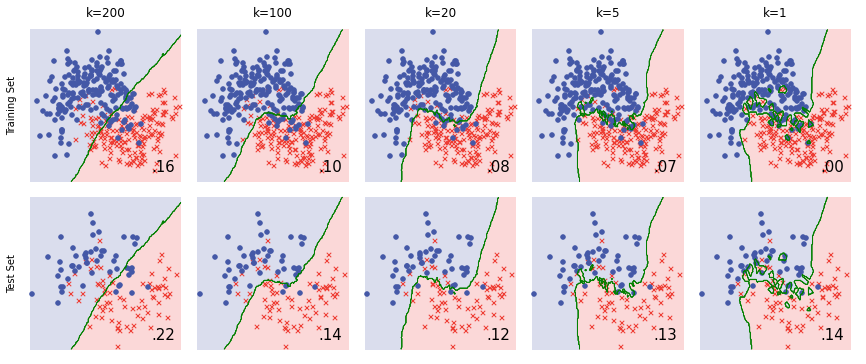

In [94]:
from matplotlib.colors import ListedColormap

model = KNeighborsClassifier()
n_neighbors = [200, 100, 20, 5, 1]
datasets = {
    "Training Set": [XTrain, yTrain],
    "Test Set": [XTest, yTest]
}
width = 15

# # explore_fitting_boundaries(model, n_neighbors, datasets, width)
explore_fitting_boundaries(model=model, n_neighbors=n_neighbors, datasets=datasets, width=width)

In [44]:
from sklearn.cross_validation import train_test_split, cross_val_score

knn = KNeighborsClassifier()

# the range of number of neighbours we want to test
n_neighbors = np.arange(1, 141, 2)

# here we store the results of each model
train_scores = list()
test_scores = list()
cv_scores = list()

for n in n_neighbors:
    knn.n_neighbors = n
    knn.fit(XTrain, yTrain)
    train_scores.append(1 - metrics.accuracy_score(yTrain, knn.predict(XTrain)))  # this will over-estimate the accuracy
    test_scores.append(1 - metrics.accuracy_score(yTest, knn.predict(XTest)))
    cv_scores.append(1 - cross_val_score(knn, XTrain, yTrain, cv = 5).mean())  # we take the mean of the CV scores

In [45]:
print('The best choice for Train would be {}, or the Test {} and with CV {}'.format(
        n_neighbors[train_scores == min(train_scores)],
        n_neighbors[test_scores == min(test_scores)],
        n_neighbors[cv_scores == min(cv_scores)]        
    )
)

The best choice for Train would be [1], or the Test [45 47 49 55 57 59 61 63 65 67 75 77 79] and with CV [15]


ValueError: x and y must have same first dimension

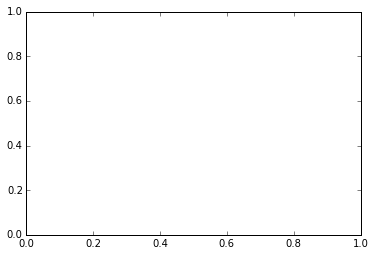

In [76]:
plt.plot(n_neighbors, train_scores, c = "grey", label = "Training Set")
plt.plot(n_neighbors, test_scores, c = "orange", label = "Test Set")
plt.plot(n_neighbors, cv_scores, c = "green", label = "CV")
plt.xlabel('Number of K nearest neighbors')
plt.ylabel('Classification Error')
plt.gca().invert_xaxis()
plt.legend(loc = "lower left")
plt.show()

## Overfitting means modelling the noise 

Overfitting just means that we start modelling the noise. The noise is something that is very particular to that one sample of the data, which does not generalize to other datasets, and that is why modelling the noise does not make us better at modelling the underlying phenomenon we are interested in. However, it is not necessarily bad to use k=1 - we could get away with using this setting if it does not lead to us capturing the noise. However, in the real world, data is messy, so you are always in danger of overfitting to the noise. Stay on your toes.

To be clear: strictly speaking, we are not trying to model the trends in the dataset. We try to model the underlying generative process that has created the data. The specific dataset we have is just a small set of instances (i.e. a sample) of the ground truth, which has its own noise and peculiarities associated with it. 

We can explore how the modelling would look if there was little noise in the data:

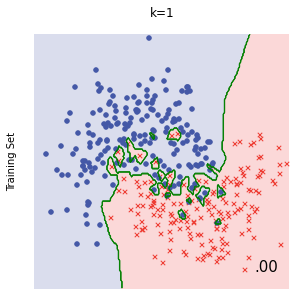

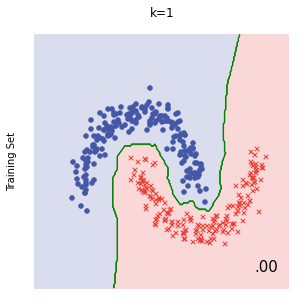

## Conclusion

In this post, we started with the motivation for tuning machine learning algorithms (i.e. nicer, bigger numbers in your models' performance reports!). We used different methods of searching over hyperparameter space, and evaluated candidate models at different points using k-fold cross validation. Tuned models were then run on the test set. Note that the concepts of training/test sets, cross-validation, and overfitting extend beyond the topic of tuning hyperparameters, though it is a nice application to demonstrate these ideas.

In this post, we tried to maximize the accuracy of our models, but there are problems for which you might want to maximize something else, like the model's specificity or the sensitivity. For example, if we were doing medical diagnostics and trying to detect a deadly illness, it would be very bad to accidentally label a sick person as healthy (this would be called a "false negative" in the lingo). Maybe it's not so bad if we misclassify healthy people as sick people ("false positive"), since in the worst case we would just annoy people by having them retake the diagnostic test. Hence, we might want our diagnostic model to be weighted towards optimizing sensitivity. [Here](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2636062/) is a good introduction to sensitivity and specificity which continues with the example of diagnostic tests.

Arguably, in spam detection, it is worse to misclassify real email as spam (false positive) than to let a few spam emails pass through your filter (false negative) and show up in people's mailboxes. In this case, we might aim to maximize specificity. Of course, we cannot be so focused on improving the specificity of our classifier that we completely bomb our sensitivity. There is a natural trade-off between these quantities (see [this primer on ROC curves](http://www.uphs.upenn.edu/radiology/education/resources/documents/receiver-operator-characteristic-analysis-primer.pdf)), and part of our job as statistical modellers is to practice the dark art of deciding where to draw the line.

Sometimes there is no tuning to be done. For example, a Naive Bayes (NB) classifier just operates by calculating conditional probabilities, and there is no real hyperparameter optimization stage. NB is actually a very interesting algorithm that is famous for classifying text documents (and the `spam` dataset in particular), so if you have time, check out a great overview and Python implementation [here]((https://bionicspirit.com/blog/2012/02/09/howto-build-naive-bayes-classifier.html)). It's a "naive" classifier because it rests on the assumption that the features in your dataset are independent, which is often not strictly true. In our spam dataset, you can image that the occurence of the strings "win", "money", and "!!!" is probably not independent. Despite this, NB often still does a decent job at classification tasks. 

In our next post, we will take these different tuned models and build them up into an ensemble model to increase our predictive performance even more. Stay... tuned! *Cue groans*.

In [ ]:
[Here](http://scott.fortmann-roe.com/docs/BiasVariance.html) is a nice introductory article on the topic that goes into more depth.

It would generalize well to new data. the other hand a too rigid model will not be able to learn particular patterns in the data and will gloss over them. Such a model would be considered to be underfitting.

All algorithms can be considered to have a certain degree of flexibility and this is not specific to kNN. Therefore the priciple of finding the sweet spot of flexibility that describes that pattern of the data well but is still generalisatble to new data is applies to all learning algorithms. A lot of work has been done in playing with the flexibility of models, for instance regularisation plays with this consideration.

Model complexity and model flexibility are often terms used to describe how ...